# Amazon Product Review Analysis 

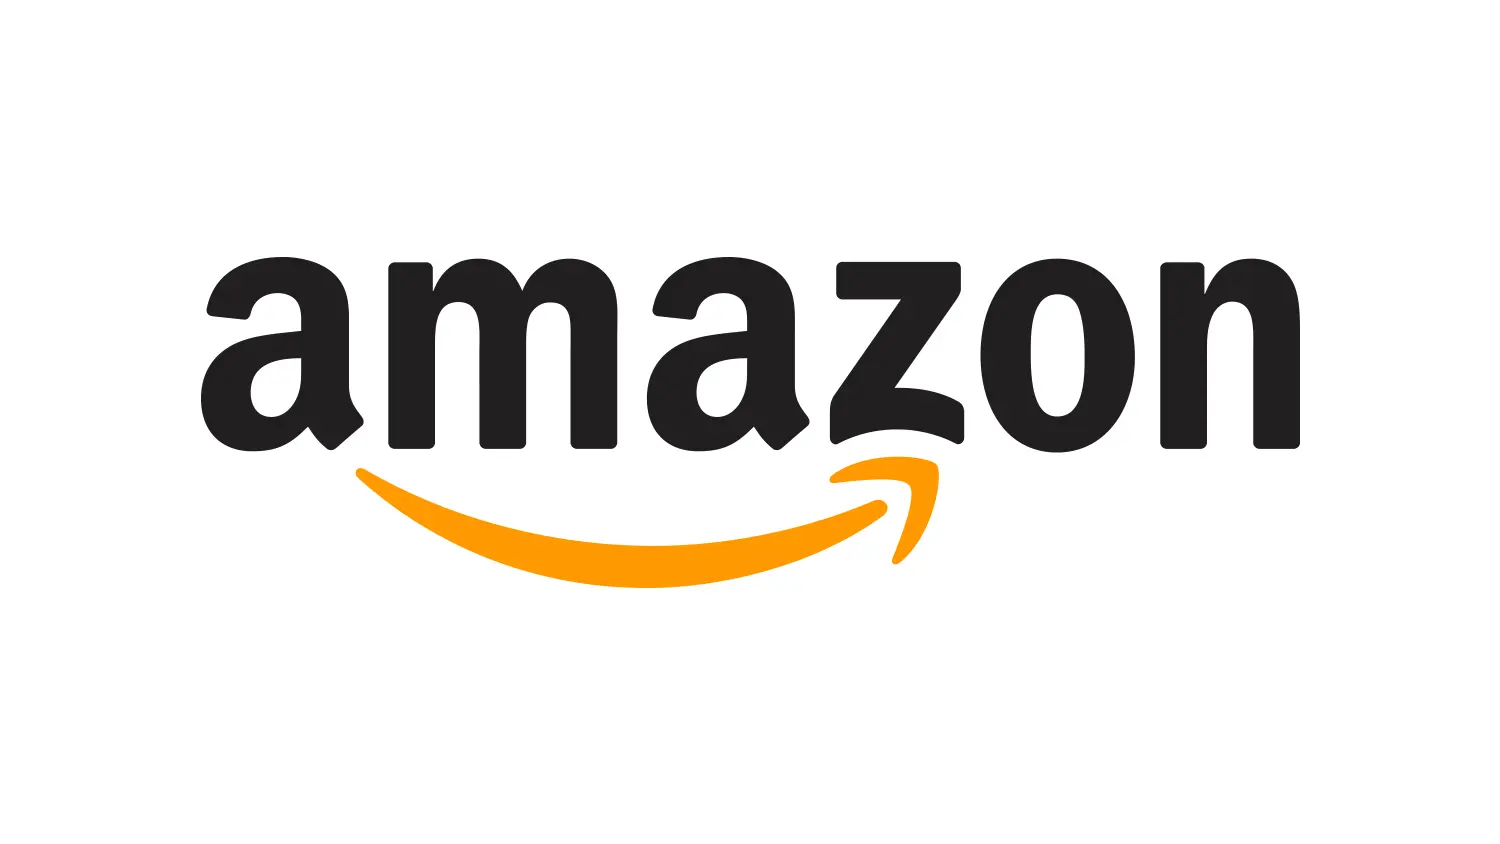

## **Introduction**
Everyday we come across various products in our lives, on the digital medium we swipe across hundreds of product choices under one category. It will be tedious for the customer to make selection. Here comes 'reviews' where customers who have already got that product leave a rating after using them and brief their experience by giving reviews. As we know ratings can be easily sorted and judged whether a product is good or bad. But when it comes to sentence reviews we need to read through every line to make sure the review conveys a positive or negative sense. In the era of artificial intelligence, things like that have got easy with the Natural Langauge Processing(NLP) technology.

A sentiment analysis on the product reviews  provided by the customers using NLP and also identifying aspects of the products from the Amazon reviews. Amazon review data analysis can give insightful customer information that can be harnessed for product betterment.

## **Problem Statement**
1. Based on 'review text' and 'Summary' of the data identify sentiments.
2. For many negative sentiments find out the reason.
3. Find out product names from input text data.
4. Predict future trends of sentiments of reviewers over the time.
5. Find interrelation between 'Digital Music' and 'Musical Instruments' categories.


## **Dataset**
### **Amazon product data:**

Dataset contains product reviews from Amazon

From **May 1996** to **July 2014** 

#### **Categories:**

 Digital Music: (64,706 reviews)

Musical Instruments: (10,261 reviews)

### **Data discription:**

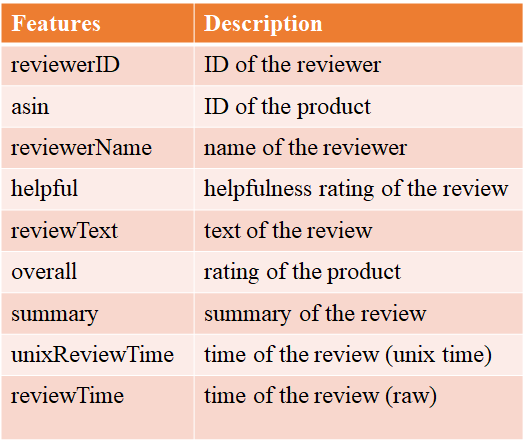

## Import Libraries

In [1]:
# mounting drive 
from google.colab import drive
drive.mount('/content/drive')

# Installing packages 
!pip install textblob
!pip install WordCloud
!pip install pyabsa
!spacy download en_core_web_sm

# basic libraries 
import re
import numpy as np
import pandas as pd
import string
import json
import gzip

# visualization libraries
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

# sentiment analysing libraries 
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from collections import defaultdict
from wordcloud import WordCloud,STOPWORDS
from pyabsa import available_checkpoints
from pyabsa import ATEPCCheckpointManager

# NER (Name Entity Recognization) libraries
import spacy
from spacy.lang.en import English
from spacy import displacy 
nlp = spacy.load('en_core_web_sm')

# time series analysis libraries
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX     
import statsmodels.api as sm   
from sklearn.metrics import mean_squared_error 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 14.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 314 kB 59.4 MB/s 
     |████████████████████████████████| 1.3 MB 62.3 MB/s 
     |████████████████████████████████| 181 kB 74.4 MB/s 
     |████████████████████████████████| 4.7 MB 66.2 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 120 kB 62.1 MB/s 
     |████████████████████████████████| 6.6 MB 61.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pytorch-warmup: filename=pytorch_warmup-0.1.0-py3-none-any.whl size=5802 sha256=a9e

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.7/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Reading the dataset 

In [2]:
# Defining function to read the data 
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
# reading the digital music data 
df_dm = getDF('/content/drive/MyDrive/Capstone Project/reviews_Digital_Music_5.json.gz')
df_dm.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5.0,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5.0,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5.0,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4.0,4.5; music to dream to,1200528000,"01 17, 2008"


In [ ]:
# reading the musical instrument data 
df_mi = getDF('/content/drive/MyDrive/Capstone Project/reviews_Musical_Instruments_5.json.gz')
df_mi.head()

## Data Preprocessing 

In [ ]:
#concatinating the both the data 
df_main = pd.concat([df_mi,df_dm],axis=0,ignore_index = True)

# printing first five instances 
df_main.head()

In [ ]:
# checking the shape of the data
print(df_main.shape) 

In [ ]:
# checking the feature names 
df_main.columns

In [ ]:
# checking the datatypes of features 
df_main.info()

In [ ]:
# creating copy of dataframe 
df_main_copy = df_main.copy()
df_main_copy.head()

In [ ]:
# checking for the null values 
print(df_main_copy.isnull().sum())

Here in this dataset for the sentiment analysis we got null values in reviewer names. Since, reviewer names doesn't add any value to our objective of the project so dropping them wouldn't be a problem.

After inspecting dataset we found some empty strings in reviewText which is not showing as null values are as follows:

In [ ]:
# checking for empty string reviews
print("Number of reviews having empty string :",df_main_copy[df_main_copy['reviewText']==''].shape[0])
df = df_main_copy[df_main_copy['reviewText']=='']
df

Hence, removing such 8 empty string reviews is necessary for sentiment analysis.

In [ ]:
# Number of reviews before removing empty string reviews
print("Number of reviews before removing empty string reviews :",df_main_copy.shape[0])

# removing empty string reviews 
for i in df.index:
  df_main_copy.drop(df_main_copy.index[i],inplace=True)

# Number of reviews after removing empty string reviews
print("Number of reviews after removing empty string reviews :",df_main_copy.shape[0])

In [ ]:
# checking for empty string summaries
print("Number of summaries having empty string :",df_main_copy[df_main_copy['summary']==''].shape[0])

There are no such empty string summaries.

In [ ]:
# resetting the indexes
df_main_copy.reset_index(drop=True,inplace=True)
df_main_copy.tail()

Concatinating Reveiwtext and summary

In [ ]:
#concatinating review text and summary and stored it in reviews
df_main_copy['reviews']=df_main_copy['reviewText']+df_main_copy['summary']
df_main_copy=df_main_copy.drop(['summary'], axis=1)
df_main_copy.head()

In [ ]:
df_main_copy.shape

From the main dataframe we can see the helpful feature with values in list [a,b] format. It says that a out of b people found that review helpful. But with that format, it could not add any value. So we are creating helpful_rate feature which returns value a/b from [a,b].



In [ ]:
#calculating the helpful rate from helpful column 
# fetching a and b values from [a,b] format
a,b=[],[]
for i in range(74959):
    a.append(df_main_copy.helpful[i][0])
    b.append(df_main_copy.helpful[i][1])  

helpful_rate = []
for i,j in zip(a,b):
    try :
        helpful_rate.append(round(i/j,2))
    except ZeroDivisionError:
        helpful_rate.append(0)

df_main_copy['helpful_rate'] = helpful_rate
df_main_copy.drop('helpful',axis=1,inplace=True)
df_main_copy.head()

In [ ]:
# count of unique helpful rates
df_main_copy.helpful_rate.value_counts()

**'0'** indicates the review **wasn't helpful** and **'1'** indicates review was **highly helpful** 


In [ ]:
# defining function to clean the text
def clean_text(text):
    # Remove all non-letters and non-spaces except for hyphens and digits
    text = re.sub("[^0-9A-Za-z- ]+", " ", text)
    # Remove all numbers except those attached to a word
    text = re.sub("(?<!\w)\d+", "", text)
    # Remove all hyphens except between two words
    text = re.sub("-(?!\w)|(?<!\w)-", "", text)
    # Remove multiple spaces and lowercase everything
    text = " ".join(text.split())
    text = text.lower()
    return text

# applying function to the dataset
df_main_copy['reviews'] = df_main_copy['reviews'].apply(clean_text)
df_main_copy.head()

In [ ]:
# Figuring out the distribution of star ratings 
df_main_copy['overall'].value_counts()

In [ ]:
# new data frame which has date and year
new = df_main_copy["reviewTime"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
df_main_copy["date"]= new[0] 
  
# making separate year column from new data frame 
df_main_copy["year"]= new[1] 

df_main_copy=df_main_copy.drop(['reviewTime'], axis=1)

# Splitting the date 
new1 = df_main_copy["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
df_main_copy["month"]= new1[0] 
  
# adding day to the main dataset 
df_main_copy["day"]= new1[1] 

df_main_copy=df_main_copy.drop(['date'], axis=1)
df_main_copy.head()

In [ ]:
# checking length of reviews
df_main_copy['review_len'] = df_main_copy['reviews'].astype(str).apply(len)
df_main_copy.head(2)

In [ ]:
# checking word count of reviews 
df_main_copy['word_count'] = df_main_copy['reviews'].apply(lambda x: len(str(x).split()))
df_main_copy.head()

## Exploratory Data Analysis

### Univariate Analysis

In [ ]:
# visualizing distribution of overall star ratings
values_dm = [35580,16536,6789,3010,2791]
values_mi = [6938,2084,772,250,217]
labels = [5,4,3,2,1]
colors = ['salmon', 'gold', 'palegreen', 'hotpink','mediumturquoise']
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=values_dm, name="Digital Music",hole=.3),row=1,col= 1)
fig.add_trace(go.Pie(labels=labels, values=values_mi, name="Musical Instruments",hole=.3),row=1, col=2)
fig.update_layout(
    title_text="Distribution of Overall Star Ratings",title_x = 0.5,font=dict(size=15),
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Digital Music', x=0.185, y=0.5, font_size=15, showarrow=False),
                 dict(text='Musical Inst.', x=0.815, y=0.5, font_size=15, showarrow=False)])
fig.update_traces(marker=dict(colors=colors, line=dict(color='black', width=1.5)))
fig.show()

In [ ]:
# visualizing distribution of overall star ratings
values = [42512, 18618, 7561, 3260,3008]
labels = [5,4,3,2,1]
# Use hole to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(values=values,labels=labels,hole=.3)])
fig.update_layout(
    title_text="Distribution of Overall Star Ratings",title_x=0.5,font=dict(size=15),
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Rating', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [ ]:
# visualizing Count of Overall Star Ratings
labels = [5,4,3,2,1]
count_dm = [i for i in df_dm.overall.value_counts()]
count_mi = [i for i in df_mi.overall.value_counts()]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=count_dm,
    name='Digital Music',
    marker_color='indianred',text=count_dm,textposition='auto'
))
fig.add_trace(go.Bar(
    x=labels,
    y=count_mi,
    name='Musical Instrument',
    marker_color='lightsalmon',text=count_mi,textposition='auto'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout( title_text="Count of Overall Ratings",barmode='group',yaxis_title='Number of reviews', xaxis_title='Ratings', 
                  font=dict(size=15, color="black"), title_x=0.5)
fig.show()

In [ ]:
# visualizing Count of Overall Star Ratings
labels = [5,4,3,2,1]
count = []
for i in df_main_copy.overall.value_counts():
  count.append(i)

fig = px.bar(x=labels, y=count, color=df_main_copy.overall.unique(), text_auto=True,title='Count of Overall Star Ratings')
fig.update_traces(showlegend=False,textfont_size=14)
fig.update_layout(yaxis_title='Number of reviews', xaxis_title='Star Ratings', font=dict(size=15, color="black"), title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
fig.show()

#### **INSIGHT**:
1. Overall **5** star rating reviews are **most** in number which is **42.51K** which contributes around **56.7%** of overall reviews. 
2. Overall **1** star rating reviews are **least** in number which is **3K** which contributes around **4%** of overall reviews. 
3. This indicates **most of the customers** are **satisfied** with their products.

In [ ]:
# visualizing Count of Overall Star Ratings
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
count_dm = [i for i in df_main_copy.month[:10261].value_counts().sort_index()]
count_mi = [i for i in df_main_copy.month[10261:].value_counts().sort_index()]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=count_dm,
    name='Digital Music',
    marker_color='paleturquoise',text=count_dm,textposition='auto'
))
fig.add_trace(go.Bar(
    x=labels,
    y=count_mi,
    name='Musical Instrument',
    marker_color='teal',text=count_mi,textposition='auto'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout( title_text="Count of Monthly Reviews",barmode='group',yaxis_title='Number of reviews', xaxis_title='Months', 
                  font=dict(size=15, color="black"), title_x=0.5)
fig.show()

In [ ]:
# visualizing Count of monthly reviews
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
count = []
for i in df_main_copy.month.value_counts().sort_index():
  count.append(i)

fig = px.bar(x=labels, y=count, color=labels, text_auto=True,title='Count of Monthly Reviews')
fig.update_traces(showlegend=False,textfont_size=14)
fig.update_layout(yaxis_title='Number of reviews', xaxis_title='Months',font=dict(size=15, color="black"), title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
fig.show()

#### **INSIGHT**:
1. Overall there is **uniformly distribution** of number of reviews over the years.
2. Still in the month of **December** there are **most** number of reviews which is around **6869** **reviews**.
3. In the month of **September** there are **least** number of reviews which is around **5430 reviews**.

In [ ]:
df_main_copy.head(1)

In [ ]:
df_main_copy.groupby(['year'])['reviewText'].count()

In [ ]:
# visualizing distribution of word count of reviews
fig = go.Figure(data=[go.Histogram(x=df_main_copy['word_count'])])
fig.update_layout(title="Distribution of count of words",yaxis_title='Number of reviews', xaxis_title='Number of words',
                  font=dict(size=15, color="black"), title_x=0.5)
fig.show()

**INSIGHT**:
1. **Most** of the **reviews** are having **count of words** between **0 to 500**
2. **Very few reviews** having **count** of words **greater than 1000**

In [ ]:
# visualizing distribution of length of reviews 
fig = go.Figure(data=[go.Histogram(x=df_main_copy['review_len'])])
fig.update_layout(title="Distribution of length of reviews",yaxis_title='Number of reviews', xaxis_title='length of reviews',
                  font=dict(size=15, color="black"), title_x=0.5)
fig.show()

**INSIGHT**:
1. **Most** of the **reviews** are having **length** between **0 to 5K**
2. **Very few reviews** having **length** **greater than 5K**

### Bivariate Analysis

In [ ]:
# visualization of most reviewed products by unique reviewers
df1 = df_dm.groupby('asin').count().loc[:,'reviewerID'].sort_values(ascending=False).head(10)

fig = px.bar(x=df1.index, y=df1,color=df1.index, text_auto=True,title='Top 10 Most Reviewed Products (Digital Music)')
fig.update_traces(showlegend=False,textfont_size=14)
fig.update_layout(yaxis_title='Number of reviewers', xaxis_title='Product ID',font=dict(size=15, color="black"), title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
print("Total number of products :",df_main_copy.asin.unique().shape[0])
fig.show()

In [ ]:
# visualization of most reviewed products by unique reviewers
df2 = df_mi.groupby('asin').count().loc[:,'reviewerID'].sort_values(ascending=False).head(10)

fig = px.bar(x=df2.index, y=df2, color=df2.index, text_auto=True,title='Top 10 Most Reviewed Products (Musical Instruments)')
fig.update_traces(showlegend=False,textfont_size=14)
fig.update_layout(yaxis_title='Number of reviewers', xaxis_title='Product ID',font=dict(size=15, color="black"), title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
print("Total number of products :",df_main_copy.asin.unique().shape[0])
fig.show()

In [ ]:
# visualization of most reviewed products by unique reviewers 
df3 = df_main_copy.groupby('asin').count().loc[:,'reviewerID'].sort_values(ascending=False).head(10)

fig = px.bar(x=df3.index, y=df3, color=df3.index, text_auto=True,title='Top 10 Most Reviewed Products')
fig.update_traces(showlegend=False,textfont_size=14)
fig.update_layout(yaxis_title='Number of reviewers', xaxis_title='Product ID',font=dict(size=15, color="black"), title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
print("Total number of products :",df_main_copy.asin.unique().shape[0])
fig.show()

#### **INSIGHT**:
1. There are **total** **4468** unique products.
2. Out of 4468 unique products **B0007NFL18**(**The Massacre by 50 cent**) is the **most reviewed** product by unique **reviewers** which is around **272**.

In [ ]:
# visualization of most reviewed products by unique reviewers 
df4 = df_mi.groupby('reviewerID').count().loc[:,'asin'].sort_values(ascending=False).head(10)

fig = px.bar(x=df4.index, y=df4, color=df4.index, text_auto=True,title='Top 10 customers (Musical Instruments)')
fig.update_traces(showlegend=False,textfont_size=14)
fig.update_layout(yaxis_title='Count of products', xaxis_title='Customer ID',font=dict(size=15, color="black"), title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
# visualization of most reviewed products by unique reviewers 
df5 = df_dm.groupby('reviewerID').count().loc[:,'asin'].sort_values(ascending=False).head(10)

fig = px.bar(x=df5.index, y=df5, color=df5.index, text_auto=True,title='Top 10 customers (Digital Music)')
fig.update_traces(showlegend=False,textfont_size=14)
fig.update_layout(yaxis_title='Count of products', xaxis_title='Customer ID',font=dict(size=15, color="black"), title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
# visualization of most reviewed products by unique reviewers 
df6 = df_main_copy.groupby('reviewerID').count().loc[:,'asin'].sort_values(ascending=False).head(10)

fig = px.bar(x=df6.index, y=df6, color=df6.index, text_auto=True,title='Top 10 customers')
fig.update_traces(showlegend=False,textfont_size=14)
fig.update_layout(yaxis_title='Count of products', xaxis_title='Customer ID',font=dict(size=15, color="black"), title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
# checking count of ratings over the years
df_main_copy.groupby(['year','overall'])['overall'].count().unstack().plot(legend=True,figsize=(17,5))
plt.title('Yearwise Change in Ratings',fontsize=18)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Count of reviews',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Ratings',fontsize=12)
plt.show()

# **1. Sentiment Analysis**

### Method 1 : TextBlob polarity score

In [ ]:
# giving polarity score to the reviews and summary
df_main_copy['polarity_reviews'] = df_main_copy['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
df_main_copy.head()

In [ ]:
# visualizing distribution of textblob polarity score 
fig = go.Figure(data=[go.Histogram(x=df_main_copy['polarity_reviews'])])
fig.update_layout(title="Distribution of textblob polarity scores",yaxis_title='Number of reviews', xaxis_title='Polarity score',
                  font=dict(size=15, color="black"), title_x=0.5)
fig.show()

### Method 2 : VADER(Valence Aware Dictionary for Sentiment Reasoning) Sentiment Analysis

In [ ]:
# defining sentiment intensity analyser function 
sia = SentimentIntensityAnalyzer()

# applying polarity scores to the reviews and summaries
df_main_copy['sia_reviews'] = df_main_copy['reviews'].map(lambda text: sia.polarity_scores(text))

# appending compound score to the dataset 
sia_reviews =[]

for i in range(74959):
  sia_reviews.append(df_main_copy['sia_reviews'][i]['compound'])
 
df_main_copy['sia_reviews'] = sia_reviews
df_main_copy.head()

In [ ]:
# visualizing distribution of VADER sentiment compound score
fig = go.Figure(data=[go.Histogram(x=df_main_copy['sia_reviews'])])
fig.update_layout(title="Distribution of VADER sentiment compound score",yaxis_title='Number of reviews', xaxis_title='Compound score',font=dict(size=15, color="black"), title_x=0.5)
fig.show()

In [ ]:
# seperating reviews and polarity scores to validate best method
df_sentiment = df_main_copy.loc[:,['reviews','polarity_reviews','sia_reviews']]

# viewing full reviews for reading purpose 
pd.set_option('display.max_colwidth', None)

# randomly sampling 20 reviews
df_sentiment.sample(n=20)

#### **INSIGHTS:**
After reading **random 20 reviews**, By using TextBlob polarity score and by VADER Sentiment analysis, **VADER Sentiment** compound score are more **accurate** towards the sentiments of the reviews

In [ ]:
# categorizing sentiments based on VADER compound score 
def sentiment(df):
      if (df['sia_reviews'] < -0.5):
        return "Strongly Negative"
      elif (df['sia_reviews'] >= -0.5) and (df['sia_reviews'] < 0):
        return "Negative"
      elif (df['sia_reviews'] == 0 ):
        return "Neutral"
      elif (df['sia_reviews'] > 0) and (df['sia_reviews'] <= 0.5):
        return "Positive"
      elif (df['sia_reviews'] > 0.5):
       return "Strongly Positive"
      
#Applying the function on new column
df_main_copy['sia_reviews_sentiment'] = df_main_copy.apply(sentiment, axis=1)
df_main_copy.head(2)

In [ ]:
# visualizing distribution of sentiments
values = [64405, 4066, 3676, 2395,417]
labels = ['Strongly Positive','Positive','Strongly Negative','Negative','Neutral']
colors = ['salmon', 'gold', 'palegreen', 'hotpink','mediumturquoise']

fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=values,hole=.4),row=1,col= 1)
fig.update_layout(
    title_text="Distribution of sentiments",title_x = 0.5,font=dict(size=15),
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Sentiments', x=0.5, y=0.5, font_size=20, showarrow=False)],legend_title_text='Sentiments')
fig.update_traces(marker=dict(colors=colors, line=dict(color='black', width=1.5)))
fig.show()

In [ ]:
# visualizing Count of sentiments
labels = ['Strongly Positive','Positive','Strongly Negative','Negative','Neutral']
count = []
for i in df_main_copy.sia_reviews_sentiment.value_counts():
  count.append(i)

fig = px.bar(x=labels, y=count, color=df_main_copy.sia_reviews_sentiment.unique(), text_auto=True,title='Count of reviews')
fig.update_traces(showlegend=False,textfont_size=14)
fig.update_layout(yaxis_title='Number of reviews', xaxis_title='sentiments', font=dict(size=15, color="black"), title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
fig.show()

**INSIGHT:**
1. **Most** of the reviews are **'Strongly Postive'** sentiment having **VADER compound score** between **0.5 to 1.0** having count **64.4K** i.e **86%** of total reviews
2. Followed by **'Positive', 'Strongly Negative'** and **'Negative'** Sentiments respectively
3. **Least** reviews are **'Neutral'** sentiment having **VADER compound score** as **0** having count **417** only i.e **0.5%** of total reviews

In [ ]:
# checking count of sentiments over the years
df_main_copy.groupby(['year','sia_reviews_sentiment'])['sia_reviews_sentiment'].count().unstack().plot(legend=True,figsize=(17,5))
plt.title('Yearwise Count of Reviews',fontsize=18)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Count of reviews',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**INSIGHT**:

1. **Strongly Positive** reviews are significantly **changing over the years**.

2. **Other sentiments** are **not changing** much over the years 

In [ ]:
# visualizing most occuring words in positive sentiments
text = df_main_copy[(df_main_copy["sia_reviews_sentiment"] == 'Positive') | (df_main_copy["sia_reviews_sentiment"] == 'Strongly Positive')]['reviews']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 8),
    facecolor = 'white',
    edgecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud of Positive Sentiments",fontsize=20)
plt.show()

**INSIGHT**:

In **positive sentiments** we can see words like **nice, good, great, well, love,affordable, expected**, etc.


In [ ]:
# visualizing most occuring words in neutral sentiments
text = df_main_copy[(df_main_copy["sia_reviews_sentiment"] == 'Neutral')]['reviews']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 8),
    facecolor = 'white',
    edgecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud of Neutral Sentiments",fontsize=20)
plt.show()

**INSIGHT**:

Most of the **Neutral review** words are focused on **products like (cable, guitar,bass, keyboard, adapter**, etc.) and how can be they improved.

In [ ]:
# visualizing most occuring words in negative sentiments
text = df_main_copy[(df_main_copy["sia_reviews_sentiment"] == 'Negative') | (df_main_copy["sia_reviews_sentiment"] == 'Strongly Negative')]['reviews']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 8),
    facecolor = 'white',
    edgecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud of Negative Sentiments",fontsize=20)
plt.show()

**INSIGHT**:
 
In **Negative sentiments** we can see words like **absurdity, pricy, wasteland, abrasive, guilty, graves**, etc.


# **2.** **Reasons for Neagtive reviews** 

In [ ]:
# extracting Negative, Strongly Negative and  Neural sentiment reviews
df_neg = df_main_copy[(df_main_copy.sia_reviews_sentiment == 'Negative') | (df_main_copy.sia_reviews_sentiment == 'Strongly Negative') | 
                      (df_main_copy.sia_reviews_sentiment == 'Neutral')]
df_neg.head(2)

In [ ]:
# checking the structure of negative sentiment dataframe
df_neg.shape

In [ ]:
# count of reviews for each product id
df_neg.asin.value_counts().head()

### Method 1: N-gram words from reviews 


In [ ]:
# defining function to generate n-gram words 
def generate_ngrams(text, n_gram=3):
    token = [token for token in text.split(" ") if token != ""]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# creating dictionary to append negative reviews according to product id
reviews_with_id = {}
c=1
for j in df_neg.asin.value_counts().head().index:
  reviews = []
  for i in df_neg[df_neg['asin']==j]['reviews']:
    reviews.append(i)
    reviews_with_id[j] = reviews
  c+=1

# creating dataframe of n-gram words and their counts
freq_dict = defaultdict(int)
for i,j in reviews_with_id.items():
  for k in j:
    for word in generate_ngrams(k):
      freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]

fd_sorted

Not getting exact reason of negative sentiments by using 3 n-gram words so let's try with the 4 n-gram words

In [ ]:
# defining function to generate n-gram words 
def generate_ngrams(text, n_gram=4):
    token = [token for token in text.split(" ") if token != ""]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# creating dictionary to append negative reviews according to product id
reviews_with_id = {}
c=1
for j in df_neg.asin.value_counts().head().index:
  reviews = []
  for i in df_neg[df_neg['asin']==j]['reviews']:
    reviews.append(i)
    reviews_with_id[j] = reviews
  c+=1

# creating dataframe of n-gram words and their counts
freq_dict = defaultdict(int)
for i,j in reviews_with_id.items():
  for k in j:
    for word in generate_ngrams(k):
      freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]

fd_sorted

By using 4 n-gram words also we are not getting exact reason of product reviews being negative

### Method 2: ATEPC(Aspect Term Extraction Polarity Classification) Method

## Negatively Reviewd Products

### Digital Music

In [ ]:
# asigning function to check sentiment of aspects 
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',auto_device=True)

# creating dictionary to append negative reviews according to product id
reviews_with_id1 = {}
c=1
for j in df_neg.asin.value_counts().head().index:
  reviews = []
  for i in df_neg[df_neg['asin']==j]['reviewText']:
    reviews.append(i)
    reviews_with_id1[j] = reviews
  c+=1

# checking sentiments of reviews according to each product id 
c= 1
for i ,j in reviews_with_id1.items():
  print('Product Number '+str(c)+' :',i)
  print(aspect_extractor.extract_aspect(inference_source=j, pred_sentiment=True))
  print('-'*100)
  print('-'*100)
  c+=1

### Musical Instruments


In [ ]:
# creating dataframe negative reviews for musical instruments
df_neg_mi = df_main_copy[:10261][(df_main_copy[:10261].sia_reviews_sentiment == 'Negative') | (df_main_copy[:10261].sia_reviews_sentiment == 'Strongly Negative') | 
                      (df_main_copy[:10261].sia_reviews_sentiment == 'Neutral')]
df_neg_mi.head()

In [ ]:
# creating dictionary to append negative reviews according to product id
reviews_with_id_mi = {}
c=1
for j in df_neg_mi.asin.value_counts().head().index:
  reviews = []
  for i in df_neg_mi[df_neg_mi['asin']==j]['reviewText']:
    reviews.append(i)
    reviews_with_id_mi[j] = reviews
  c+=1

# checking sentiments of reviews according to each product id 
c= 1
for i ,j in reviews_with_id_mi.items():
  print('Product Number '+str(c)+' :',i)
  print(aspect_extractor.extract_aspect(inference_source=j, pred_sentiment=True))
  print('-'*100)
  print('-'*100)
  c+=1

In [ ]:
# appending product id's
id1 = [i for i in reviews_with_id1.keys()]
id2 = [i for i in reviews_with_id_mi.keys()]
id = id1+id2

# creating dataframe to show reasons according to each product 
pd.DataFrame({'Product Id':id,'Product Name':['The Massacre by 50 Cent',"Get Rich Or Die Tryin' by 50 Cent",'The Marshall Mathers by Eminem',
                                               'Beg for Mercy by G-unit','Encore by Eminem','Planet Waves DP0002 Pro String Winder and Cutter',
                                               'Hosa GTR-210 Straight Guitar Cable, 10 feet','Dunlop Pickholder','Snark SN-1 Clip-On Guitar and Bass Tuner',
                                              'Nady MPF-6 6-inch Clamp On Microphone Pop Filter with Flexible Gooseneck and Metal Stabilizing Arm'],
              'Reasons':['Lyrics & beats was not good. The hype of artist is starting to fade.',
                         'The artist was targeting some other artists which was not going well with the fans.',
                         'Language used by the artist was not appropriate.',
                         'In the Group "G-Unit" other than 50 Cents other artist failed to make any impact on the audience.',
                         'Songwriting and production was not good.',
                         'The String winder tool for guitars is not upto the mark.',
                         'The Hosa cable gives crackling sound while plug-in to the amplifier. The length of the cable is very short. The threads of the cable peels off easily.',
                         'The pick holder carries only 3 pick instead of what the company claimed of 6. The color of the product is not the same as shown on the site.',
                         'The quality of the product is not good & it drains the battery very quickly.',
                         'The alignment of Popfilter is sightly off from the centre.']})

In [ ]:
# extracting Negative, Strongly Negative and  Neural sentiment reviews
df_pos = df_main_copy[(df_main_copy.sia_reviews_sentiment == 'Positive') | (df_main_copy.sia_reviews_sentiment == 'Strongly Positive')]
df_pos.head(2)

## Positively Reviewed Products

### Digital Music

In [ ]:
df_pos_dm= df_main_copy[10261:][(df_main_copy[10261:].sia_reviews_sentiment == 'Positive') | (df_main_copy[10261:].sia_reviews_sentiment == 'Strongly Positive')]
df_pos_dm.shape

In [ ]:
# creating dictionary to append negative reviews according to product id
reviews_with_id_dm = {}
c=1
for j in df_pos_dm.asin.value_counts().head().index:
  reviews = []
  for i in df_pos_dm[df_pos_dm['asin']==j]['reviewText']:
    reviews.append(i)
    reviews_with_id_dm[j] = reviews
  c+=1

# checking sentiments of reviews according to each product id 
c= 1
for i ,j in reviews_with_id_dm.items():
  print('Product Number '+str(c)+' :',i)
  print(aspect_extractor.extract_aspect(inference_source=j, pred_sentiment=True))
  print('-'*100)
  print('-'*100)
  c+=1

### Musical Instruments

In [ ]:
df_pos_mi= df_main_copy[:10261][(df_main_copy[:10261].sia_reviews_sentiment == 'Positive') | (df_main_copy[:10261].sia_reviews_sentiment == 'Strongly Positive')]
df_pos_mi.shape

In [ ]:
# creating dictionary to append negative reviews according to product id
reviews_with_id_mi = {}
c=1
for j in df_pos_mi.asin.value_counts().head().index:
  reviews = []
  for i in df_pos_mi[df_pos_mi['asin']==j]['reviewText']:
    reviews.append(i)
    reviews_with_id_mi[j] = reviews
  c+=1

# checking sentiments of reviews according to each product id 
c= 1
for i ,j in reviews_with_id_mi.items():
  print('Product Number '+str(c)+' :',i)
  print(aspect_extractor.extract_aspect(inference_source=j, pred_sentiment=True))
  print('-'*100)
  print('-'*100)
  c+=1

In [ ]:
reviews_with_id_mi.keys()

In [ ]:
# appending product id's
id1 = [i for i in reviews_with_id_dm.keys()]
id2 = [i for i in reviews_with_id_mi.keys()]
id = id1+id2

# creating dataframe to show reasons according to each product 
pd.DataFrame({'Product Id':id,'Product Name':["Get Rich Or Die Tryin' by 50 Cent",'The Massacre by 50 Cent', 'Come Away with Me by Norah Jones',
                                              'Eminem Show by Eminem','Speakerboxxx: Love Below by Outkast', 'Snark SN-1 Clip-On Guitar and Bass Tuner',
                                              'Planet Waves DP0002 Pro String Winder and Cutter (Multicolor)',
                                              "D'Addario Electric Regular {Light Gauge10/46 BRIGHT TONE ROUND WOUND} Guitar Strings (Bronze)",
                                              'Snark SN-2 All Instrument Clip-On Chromatic Tuner',"D'Addario EJ26 Acoustic 11-52 Custom Light Guitar Strings"],
              'Reasons':['Worth the money',
                         'Inspirational, joy and positive vibes',
                         "Artist's voice is amazing. Calming music.",
                         'Lyrics are extraordinary from the beloved artist',
                         'High energy, great vocals and ecstatic beats',
                         'Works very well and easier to read',
                         'Winder winds the string quite well with attached cutter cuts the excessive strings cleanly.',
                         'Good Quality & Durable, break in quickly and hold there tune properly. Works for all styles of play.',
                         'It is versetile product and works on various musical instruments (guitar, trumpet, etc.) and also works on mics. Delivery is fast as well.',
                         'Packaging is good and price is reasonable. It is copper coated hence more durable.']})

# **3. Product names from reviews**

### Using NER (Name Entity Recognization) method  

In [ ]:
# displaying different tags from reviews 
doc1 = nlp(str(df_dm['reviewText'][1:2]))
displacy.render(doc1,style='ent',jupyter=True)

**INSIGHT**:

By using NER we are getting name of the product is tagged as ORG(organization)

### Digital Music

In [ ]:
# finding organization tagged words from reviews for each product id 
prd_id=[]
c=1
for j in df_dm.asin.unique()[:10]:
  prd_id.append(j)
  print('Product',str(c),':',j)
  print('-'*50)
  for i in df_dm[df_dm['asin']==j]['reviewText']:
    dat= nlp(i)
    for w in dat.ents:
      if w.label_=='ORG':
        print("text =",w.text, " | entity =",w.label_,'| count =',(i.count(w.text)))
        print('-'*20)
  c+=1
  print('*'*50)
  print('*'*50)

In [ ]:
# creating dataframe of product id and their respective names 
dic = {'Product ID': prd_id, 
       'Product Name': ['The Memory of Trees (Studio album by) Enya','Changing Faces (by) R&B (duo)','Candy-O (Song by The) Cars',
        'Surfin’ USA (Song by) Brian Wilson (and The) Beach Boys','Samba de uma Nota Só (Samba de uma nota só Song by) Antônio Carlos Jobim',
        'That Secret Place (by) Patti', 'Too Late To Cry (by) Alison Krauss (and) Union Station Alison Krauss ','Two Highways (by) Alison Krauss',
        "I've Got That Old Feeling (by) Alison Krauss", "Now That I've Found (by) Alison Krauss"]}

pd.DataFrame(dic)

From above dataframe,

In Product Names which are not in brackets are tagged as ORG(organization) and 

words which are in brackets are inserted manually 


In [ ]:
# finding organization tagged words from reviews for each product id 
prd_id = []
c=1
for j in df_mi.asin.unique()[:50]:
  prd_id.append(j)
  print('Product',str(c),':',j)
  print('-'*50)
  for i in df_mi[df_mi['asin']==j]['reviewText']:
    dat= nlp(i)
    for w in dat.ents:
      if w.label_=='ORG':
        print("text =",w.text, " | entity =",w.label_,'| count =',(i.count(w.text)))
        print('-'*20)
  c+=1
  print('*'*50)
  print('*'*50)

In [ ]:
# creating dataframe of product id and their respective names 
dic = {'Product ID': ['B0002D0096','B0002CZV82','B0000AQRSU','B0002CZV7I','B0002CZUUG','B0002CZST4','B0002CZSJO','B0002BACB4','B000068O1N','B000068NW5'], 
       'Product Name': ['Roland MICRO-CUBE (Guitar Combo) Amplifier','Boss DS-1 (Distortion Pedal by) BOSS',
        'Shure SM58S (Vocal Microphone with On/Off Switch)', 'Boss CS-3 (Compressor/Sustainer Pedal)',
        'Epiphone LP (Special II) Les Paul (Electric Guitar), Ebony','Martin M170 (Acoustic 80/20 Guitar Strings, Extra Light)',
        'Kyser KG6S (Quick-Change Capo for 6 String Acoustic Guitar, Silver)',
        'Shure Beta 58A (Unidirectional Auxiliary Dynamic Vocal Microphone)',
        "Hosa STP-201 (1/4 inch TRS to Dual 1/4 inch TS Insert Cable, 3.3 feet)", "Hosa GTR-210 (Straight Guitar Cable, 10 feet)"]}

pd.DataFrame(dic)

From above dataframe,

In Product Names which are not in brackets are tagged as ORG(organization) and 

words which are in brackets are inserted manually 


# **4. Time Series Analysis on sentiments**

### Musical Instruments

In [ ]:
# creating date column by concatenating year, month and day features
df_main_copy['date'] = pd.to_datetime(df_main_copy[["year","month","day"]])

# fetching musical instrument data only 
df_mi_ts = df_main_copy[:10261].loc[:,["sia_reviews_sentiment","date"]]
df_mi_ts.head()

In [ ]:
# checking the shape of the data
print(df_mi_ts.shape) 

In [ ]:
# checking the datatypes of features 
df_mi_ts.info()

In [ ]:
# sorting the values by date 
df_mi_ts = df_mi_ts.sort_values(by=['date'])

# setting date column as index 
df_mi_ts = df_mi_ts.set_index('date')
df_mi_ts.head()

### Positive sentiments 

Positive sentiments includes Strongly positive and positive categories of sentiments

In [ ]:
# fetching only positive sentiments 
df_mi_ts_pos = df_mi_ts[(df_mi_ts.sia_reviews_sentiment == 'Positive') | (df_mi_ts.sia_reviews_sentiment == 'Strongly Positive')]
df_mi_ts_pos.head()

In [ ]:
df_mi_ts_pos

In [ ]:
# resampling sentiments as per months
df_mi_ts_pos = df_mi_ts_pos.resample("MS").count()
df_mi_ts_pos.head()

In [ ]:
# checking the shape of the data
print(df_mi_ts_pos.shape) 

In [ ]:
# visualizing count of positive reviews 
fig = px.line(df_mi_ts_pos, x=df_mi_ts_pos.index, y="sia_reviews_sentiment", title='Musical Instrument Positive Reviews')
fig.update_layout(xaxis_title="Date",yaxis_title="Count of reviews",font=dict(size=15),title_x = 0.5)
fig.show()

In [ ]:
# Time Series Components
# season_decompose breaks the data in components
decomp = seasonal_decompose(df_mi_ts_pos,period=12) 

d_trend = decomp.trend
d_seasonal = decomp.seasonal
d_residual = decomp.resid

# plot the components
fig,ax = plt.subplots(4,1,figsize=(17,10))

plt.subplot(411)
plt.plot(df_mi_ts_pos,label = 'Monthly data')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(d_trend,label = 'Trend')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(d_seasonal,label='Seasonal')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(d_residual,label='Random')
plt.legend(loc='upper right');


Since there is seasonality and trend we are using sarima model.

In [ ]:
# creating function to check stationarity of the data 
def checkStationarity (data):
  pvalue = adfuller(data)[1]
  if pvalue < 0.05:
    ret = "Data is stationary. Proceed to model building"
  else:
    ret = "Data is not stationary. Make it statioanry"
  return(ret)

#checking stationarity of data 
checkStationarity(df_mi_ts_pos)

In [ ]:
#1-level difference
diff_data_pos1 = df_mi_ts_pos['sia_reviews_sentiment']-df_mi_ts_pos['sia_reviews_sentiment'].shift()

# creating dataframe of actual and differenced data
pd.DataFrame({'Actual_data':df_mi_ts_pos['sia_reviews_sentiment'],'difference data':diff_data_pos1})

In [ ]:
# dropping null values from the differenced data
diff_data_pos1.dropna(inplace=True)

# checking stationarity of differenced data 
checkStationarity(diff_data_pos1)

In [ ]:
# 2-level difference
diff_data_pos2 = diff_data_pos1-diff_data_pos1.shift()

# creating dataframe of actual and differenced data
pd.DataFrame({'Actual_data':df_mi_ts_pos['sia_reviews_sentiment'],'difference data':diff_data_pos2})

In [ ]:
# dropping null values from the differenced data
diff_data_pos2.dropna(inplace=True)

# checking stationarity of differenced data 
checkStationarity(diff_data_pos2)

#### Model Building

In [ ]:
# plotting ACF and PACF
diff_data_pos_acf = acf(diff_data_pos2)   
diff_data_pos_pacf = pacf(diff_data_pos2)
N = len(diff_data_pos2)
SE = 1.96/np.sqrt(len(diff_data_pos2))

fig,ax = plt.subplots(figsize= (10,7))

plt.subplot(121)
plt.plot(diff_data_pos_pacf)
plt.axhline(y=0, linestyle = "--",color = "red")
plt.axhline(y=SE,linestyle="--",color="gray")
plt.axhline(y=-SE,linestyle="--",color="gray")
plt.title("Partial Auto Correlation Fuction")

plt.subplot(122)
plt.plot(diff_data_pos_acf)
plt.axhline(y=0, linestyle = "--",color = "red")
plt.axhline(y=SE,linestyle="--",color="gray")
plt.axhline(y=-SE,linestyle="--",color="gray")
plt.title("Auto Correlation Fuction")

In [ ]:
# plotting ACF and PACF
fig,ax = plt.subplots(2,1, figsize = (17,10))
plot_pacf(diff_data_pos2, ax=ax[0])
plot_acf(diff_data_pos2, ax=ax[1])
plt.show();

Taking p and q values in the range of 0 to 3

In [ ]:
# split the data into train and test
rows = int(0.8*len(df_mi_ts_pos)) 

# while splitting always specify column name
train_mi_pos = df_mi_ts_pos.iloc[:rows]
test_mi_pos = df_mi_ts_pos.iloc[rows:]

print('Train={}, Test={}'.format(len(train_mi_pos), len(test_mi_pos)))

In [ ]:
# creating list of p and q value combinations 
lis=[]
for p in range(3):
    for q in range(3):
        lis.append((p,2,q))

lis1=[]
for p in range(3):
    for q in range(3):
        lis1.append((p,2,q,12))

# building model
model=[]
for i,j in zip(lis,lis1):
    m = SARIMAX(train_mi_pos, order=i,seasonal_order=j).fit() 
    model.append(m)

# checking model is good or not
c=1
good_model =[]
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        good_model.append(i)
        print(f'Model {c} Good model')
    c+=1

In [ ]:
# calculating AIC and BIC score
aic=[]
bic=[]
for i in good_model:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in good_model:
    fcast = i.predict(start=len(train_mi_pos), end=len(train_mi_pos)+len(test_mi_pos)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test_mi_pos, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# dataframe of all results
df_results = pd.DataFrame({'Model No.': ['Model 3','Model 5','Model 6','Model 7','Model 8','Model 9'], 
                           '(p, d, q)':[(0, 2, 2), (1, 2, 1), (1, 2, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)], 
                           'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

In [ ]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]

In [ ]:
# visualizing train, test and predicted data by the model
plt.figure(figsize=(17,5))
plt.plot(train_mi_pos,label='Train data',color='teal')
plt.plot(test_mi_pos,label='Test data',color='green')
plt.plot(forecast[1],label='Predict data',color='red')
plt.title('Musical Instruments positive reviews', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of reviews', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

In [ ]:
# building model on whole dataset
model_5 = SARIMAX(df_mi_ts_pos['sia_reviews_sentiment'], order=(1,2,1),seasonal_order=(1,2,1,12)).fit()

# predicting next 24 months 
sarima_fcast = model_5.predict('2014-08-01','2016-08-01')

# visualizing actual and forecasted data 
plt.figure(figsize=(17,5))
plt.plot(df_mi_ts_pos['sia_reviews_sentiment'],label='Actual data',color='teal')
plt.plot(sarima_fcast,label='Forecast data',color='red')
plt.title('Musical Instruments positive reviews', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of reviews', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

**INSIGHT**: 

1. Overall **increase** in postive reviews 

2. Positive reviews tends to be **increasing** after **july 2014**

### Negative sentiments 

Negative sentiments includes Strongly Negative, Negative and Neutral categories of sentiments

In [ ]:
# fetching only positive sentiments 
df_mi_ts_neg = df_mi_ts[(df_mi_ts.sia_reviews_sentiment == 'Negative') | (df_mi_ts.sia_reviews_sentiment == 'Strongly Negative') 
                         | (df_mi_ts.sia_reviews_sentiment == 'Neutral') ]
df_mi_ts_neg.head()

In [ ]:
# resampling sentiments as per months
df_mi_ts_neg = df_mi_ts_neg.resample("MS").count()
df_mi_ts_neg.head()

In [ ]:
# checking the shape of the data
print(df_mi_ts_neg.shape) 

In [ ]:
# visualizing count of positive reviews 
fig = px.line(df_mi_ts_neg, x=df_mi_ts_neg.index, y="sia_reviews_sentiment", title='Musical Instrument Negative Reviews')
fig.update_layout(xaxis_title="Date",yaxis_title="Count of reviews",font=dict(size=15),title_x = 0.5)
fig.show()

In [ ]:
# Time Series Components
# season_decompose breaks the data in components
decomp = seasonal_decompose(df_mi_ts_neg,period=12) 

d_trend = decomp.trend
d_seasonal = decomp.seasonal
d_residual = decomp.resid

# plot the components
fig,ax = plt.subplots(4,1,figsize=(17,10))

plt.subplot(411)
plt.plot(df_mi_ts_neg,label = 'Monthly data')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(d_trend,label = 'Trend')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(d_seasonal,label='Seasonal')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(d_residual,label='Random')
plt.legend(loc='upper right');

Since there is seasonality and trend we are using sarima model.

In [ ]:
#checking stationarity of data 
checkStationarity(df_mi_ts_neg)

In [ ]:
#1-level difference
diff_data_neg1 = df_mi_ts_neg['sia_reviews_sentiment']-df_mi_ts_neg['sia_reviews_sentiment'].shift()

# creating dataframe of actual and differenced data
pd.DataFrame({'Actual_data':df_mi_ts_neg['sia_reviews_sentiment'],'difference data':diff_data_neg1})

In [ ]:
# dropping null values from the differenced data
diff_data_neg1.dropna(inplace=True)

# checking stationarity of differenced data 
checkStationarity(diff_data_neg1)

In [ ]:
# 2-level difference
diff_data_neg2 = diff_data_neg1-diff_data_neg1.shift()

# creating dataframe of actual and differenced data
pd.DataFrame({'Actual_data':df_mi_ts_neg['sia_reviews_sentiment'],'difference data':diff_data_neg2})

In [ ]:
# dropping null values from the differenced data
diff_data_neg2.dropna(inplace=True)

# checking stationarity of differenced data 
checkStationarity(diff_data_neg2)

In [ ]:
diff_data_neg2

#### Model Building

In [ ]:
# plotting ACF and PACF
diff_data_neg_acf = acf(diff_data_neg2)   
diff_data_neg_pacf = pacf(diff_data_neg2,nlags=12)
N = len(diff_data_neg2)
SE = 1.96/np.sqrt(len(diff_data_neg2))

fig,ax = plt.subplots(figsize= (10,7))

plt.subplot(121)
plt.plot(diff_data_neg_pacf)
plt.axhline(y=0, linestyle = "--",color = "red")
plt.axhline(y=SE,linestyle="--",color="gray")
plt.axhline(y=-SE,linestyle="--",color="gray")
plt.title("Partial Auto Correlation Fuction")

plt.subplot(122)
plt.plot(diff_data_neg_acf)
plt.axhline(y=0, linestyle = "--",color = "red")
plt.axhline(y=SE,linestyle="--",color="gray")
plt.axhline(y=-SE,linestyle="--",color="gray")
plt.title("Auto Correlation Fuction")

In [ ]:
# plotting ACF and PACF
fig,ax = plt.subplots(2,1, figsize = (17,10))
plot_pacf(diff_data_neg2, ax=ax[0])
plot_acf(diff_data_neg2, ax=ax[1])
plt.show();

Taking p and q values in the range of 0 to 3

In [ ]:
# split the data into train and test
rows = int(0.8*len(df_mi_ts_neg)) 

# while splitting always specify column name
train_mi_neg = df_mi_ts_neg.iloc[:rows]
test_mi_neg = df_mi_ts_neg.iloc[rows:]

print('Train={}, Test={}'.format(len(train_mi_neg), len(test_mi_neg)))

In [ ]:
# creating list of p and q value combinations 
lis=[]
for p in range(3):
    for q in range(3):
        lis.append((p,2,q))

lis1=[]
for p in range(3):
    for q in range(3):
        lis1.append((p,2,q,12))

# building model
model=[]
for i,j in zip(lis,lis1):
    m = SARIMAX(train_mi_neg, order=i,seasonal_order=j).fit() 
    model.append(m)

# checking model is good or not
c=1
good_model =[]
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        good_model.append(i)
        print(f'Model {c} Good model')
    c+=1

In [ ]:
# calculating AIC and BIC score
aic=[]
bic=[]
for i in good_model:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in good_model:
    fcast = i.predict(start=len(train_mi_neg), end=len(train_mi_neg)+len(test_mi_neg)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test_mi_neg, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# appending model numbers 
model_no = ['Model '+str(i) for i in range(3,10)]

# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, 
                           '(p, d, q)':lis[2:], 
                           'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

In [ ]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]

In [ ]:
# visualizing train, test and predicted data by the model
plt.figure(figsize=(17,5))
plt.plot(train_mi_neg,label='Train data',color='teal')
plt.plot(test_mi_neg,label='Test data',color='green')
plt.plot(forecast[4],label='Predict data',color='red')
plt.title('Musical Instruments negative reviews', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of reviews', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

In [ ]:
# building model on whole dataset
model_7 = SARIMAX(df_mi_ts_neg['sia_reviews_sentiment'], order=(2,2,0),seasonal_order=(2,2,0,12)).fit()

# predicting next 24 months 
sarima_fcast = model_7.predict('2014-08-01','2016-08-01')

# visualizing actual and forecasted data 
plt.figure(figsize=(17,5))
plt.plot(df_mi_ts_neg['sia_reviews_sentiment'],label='Actual data',color='teal')
plt.plot(sarima_fcast,label='Forecast data',color='red')
plt.title('Musical Instruments negative reviews', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of reviews', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

**INSIGHT**: 

1. Overall **increase** in negative reviews 

2. Negative reviews tends to be **increasing** after **july 2014**

# Digital Music

In [ ]:
# fetching musical instrument data only 
df_dm_ts = df_main_copy[10262:].loc[:,["sia_reviews_sentiment","date"]]
df_dm_ts.head()

In [ ]:
# checking the shape of the data
print(df_dm_ts.shape) 

In [ ]:
# checking the datatypes of features 
df_dm_ts.info()

In [ ]:
# sorting the values by date 
df_dm_ts = df_dm_ts.sort_values(by=['date'])

# setting date column as index 
df_dm_ts = df_dm_ts.set_index('date')
df_dm_ts.head()

### Positive sentiments

Positive sentiments includes Strongly positive and positive categories of sentiments

In [ ]:
# fetching only positive sentiments 
df_dm_ts_pos = df_dm_ts[(df_dm_ts.sia_reviews_sentiment == 'Positive') | (df_dm_ts.sia_reviews_sentiment == 'Strongly Positive')]
df_dm_ts_pos.head()

In [ ]:
# resampling sentiments as per months
df_dm_ts_pos = df_dm_ts_pos.resample("MS").count()
df_dm_ts_pos.head()

In [ ]:
# checking the shape of the data
print(df_dm_ts_pos.shape) 

In [ ]:
# visualizing count of positive reviews 
fig = px.line(df_dm_ts_pos, x=df_dm_ts_pos.index, y="sia_reviews_sentiment", title='Digital Music Positive Reviews')
fig.update_layout(xaxis_title="Date",yaxis_title="Count of reviews",font=dict(size=15),title_x = 0.5)
fig.show()

In [ ]:
# Time Series Components
# season_decompose breaks the data in components
decomp = seasonal_decompose(df_dm_ts_pos,period=12) 

d_trend = decomp.trend
d_seasonal = decomp.seasonal
d_residual = decomp.resid

# plot the components
fig,ax = plt.subplots(4,1,figsize=(17,10))

plt.subplot(411)
plt.plot(df_dm_ts_pos,label = 'Monthly data')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(d_trend,label = 'Trend')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(d_seasonal,label='Seasonal')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(d_residual,label='Random')
plt.legend(loc='upper right');

Since there is seasonality, we are using sarima model.

In [ ]:
#checking stationarity of data 
checkStationarity(df_dm_ts_pos)

In [ ]:
#1-level difference
diff_data_pos1 = df_dm_ts_pos['sia_reviews_sentiment']-df_dm_ts_pos['sia_reviews_sentiment'].shift()

# creating dataframe of actual and differenced data
pd.DataFrame({'Actual_data':df_dm_ts_pos['sia_reviews_sentiment'],'difference data':diff_data_pos1})

In [ ]:
# 2-level difference
diff_data_pos2 = diff_data_pos1-diff_data_pos1.shift()

# creating dataframe of actual and differenced data
pd.DataFrame({'Actual_data':df_dm_ts_pos['sia_reviews_sentiment'],'difference data':diff_data_pos2})

In [ ]:
# dropping null values from the differenced data
diff_data_pos2.dropna(inplace=True)

# checking stationarity of differenced data 
checkStationarity(diff_data_pos2)

### Model Building

In [ ]:
# plotting ACF and PACF
diff_data_pos_acf = acf(diff_data_pos2)   
diff_data_pos_pacf = pacf(diff_data_pos2)
N = len(diff_data_pos2)
SE = 1.96/np.sqrt(len(diff_data_pos2))

fig,ax = plt.subplots(figsize= (10,7))

plt.subplot(121)
plt.plot(diff_data_pos_pacf)
plt.axhline(y=0, linestyle = "--",color = "red")
plt.axhline(y=SE,linestyle="--",color="gray")
plt.axhline(y=-SE,linestyle="--",color="gray")
plt.title("Partial Auto Correlation Fuction")

plt.subplot(122)
plt.plot(diff_data_pos_acf)
plt.axhline(y=0, linestyle = "--",color = "red")
plt.axhline(y=SE,linestyle="--",color="gray")
plt.axhline(y=-SE,linestyle="--",color="gray")
plt.title("Auto Correlation Fuction")

In [ ]:
# plotting ACF and PACF
fig,ax = plt.subplots(2,1, figsize = (17,10))
plot_pacf(diff_data_pos2, ax=ax[0])
plot_acf(diff_data_pos2, ax=ax[1])
plt.show();

Taking p and q values in the range of 0 to 3

In [ ]:
# split the data into train and test
rows = int(0.8*len(df_dm_ts_pos)) 

# while splitting always specify column name
train_dm_pos = df_dm_ts_pos.iloc[:rows]
test_dm_pos = df_dm_ts_pos.iloc[rows:]

print('Train={}, Test={}'.format(len(train_dm_pos), len(test_dm_pos)))

In [ ]:
# creating list of p and q value combinations 
lis=[]
for p in range(3):
    for q in range(3):
        lis.append((p,2,q))

lis1=[]
for p in range(3):
    for q in range(3):
        lis1.append((p,2,q,12))

# building model
model=[]
for i,j in zip(lis,lis1):
    m = SARIMAX(train_dm_pos, order=i,seasonal_order=j).fit() 
    model.append(m)

# checking model is good or not
c=1
good_model =[]
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        good_model.append(i)
        print(f'Model {c} Good model')
    c+=1

In [ ]:
# calculating AIC and BIC score
aic=[]
bic=[]
for i in good_model:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in good_model:
    fcast = i.predict(start=len(train_dm_pos), end=len(train_dm_pos)+len(test_dm_pos)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test_dm_pos, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# dataframe of all results
df_results = pd.DataFrame({'Model No.': ['Model 3','Model 5','Model 6','Model 8'], 
                           '(p, d, q)':[(0, 2, 2), (1, 2, 1), (1, 2, 2), (2, 2, 1)], 
                           'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

In [ ]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]

In [ ]:
# visualizing train, test and predicted data by the model
plt.figure(figsize=(17,5))
plt.plot(train_dm_pos,label='Train data',color='teal')
plt.plot(test_dm_pos,label='Test data',color='green')
plt.plot(forecast[3],label='Predict data',color='red')
plt.title('Digital Music positive reviews', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of reviews', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

In [ ]:
# building model on whole dataset
model_6 = SARIMAX(df_dm_ts_pos['sia_reviews_sentiment'], order=(2,2,1),seasonal_order=(2,2,1,12)).fit()

# predicting next 24 months 
sarima_fcast = model_6.predict('2014-08-01','2016-08-01')

# visualizing actual and forecasted data 
plt.figure(figsize=(17,5))
plt.plot(df_dm_ts_pos['sia_reviews_sentiment'],label='Actual data',color='teal')
plt.plot(sarima_fcast,label='Forecast data',color='red')
plt.title('Digital Music positive reviews', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of reviews', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

**INSIGHT**: 

1. Overall **constant trend** in postive reviews 

2. Positive reviews tends to be **constant** after **july 2014**

### Negative sentiments

Negative sentiments includes Strongly Negative, Negative and Neutral categories of sentiments

In [ ]:
# fetching only positive sentiments 
df_dm_ts_neg = df_dm_ts[(df_dm_ts.sia_reviews_sentiment == 'Negative') | (df_dm_ts.sia_reviews_sentiment == 'Strongly Negative') 
                         | (df_dm_ts.sia_reviews_sentiment == 'Neutral') ]
df_dm_ts_neg.head()

In [ ]:
# resampling sentiments as per months
df_dm_ts_neg = df_dm_ts_neg.resample("MS").count()
df_dm_ts_neg.head()

In [ ]:
# checking the shape of the data
print(df_dm_ts_neg.shape) 

In [ ]:
# visualizing count of positive reviews 
fig = px.line(df_dm_ts_neg, x=df_dm_ts_neg.index, y="sia_reviews_sentiment", title='Digital Music Negative Reviews')
fig.update_layout(xaxis_title="Date",yaxis_title="Count of reviews",font=dict(size=15),title_x = 0.5)
fig.show()

In [ ]:
# Time Series Components
# season_decompose breaks the data in components
decomp = seasonal_decompose(df_dm_ts_neg,period=12) 

d_trend = decomp.trend
d_seasonal = decomp.seasonal
d_residual = decomp.resid

# plot the components
fig,ax = plt.subplots(4,1,figsize=(17,10))

plt.subplot(411)
plt.plot(df_dm_ts_neg,label = 'Monthly data')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(d_trend,label = 'Trend')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(d_seasonal,label='Seasonal')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(d_residual,label='Random')
plt.legend(loc='upper right');

Since there is seasonality, we are using sarima model.

In [ ]:
#checking stationarity of data 
checkStationarity(df_dm_ts_neg)

In [ ]:
#1-level difference
diff_data_neg1 = df_dm_ts_neg['sia_reviews_sentiment']-df_dm_ts_neg['sia_reviews_sentiment'].shift()

# creating dataframe of actual and differenced data
pd.DataFrame({'Actual_data':df_dm_ts_neg['sia_reviews_sentiment'],'difference data':diff_data_neg1})

In [ ]:
# 2-level difference
diff_data_neg2 = diff_data_neg1-diff_data_neg1.shift()

# creating dataframe of actual and differenced data
pd.DataFrame({'Actual_data':df_dm_ts_neg['sia_reviews_sentiment'],'difference data':diff_data_neg2})

In [ ]:
# dropping null values from the differenced data
diff_data_neg2.dropna(inplace=True)

# checking stationarity of differenced data 
checkStationarity(diff_data_neg2)

### Model Building

In [ ]:
# plotting ACF and PACF
diff_data_neg_acf = acf(diff_data_neg2)   
diff_data_neg_pacf = pacf(diff_data_neg2)
N = len(diff_data_neg2)
SE = 1.96/np.sqrt(len(diff_data_neg2))

fig,ax = plt.subplots(figsize= (10,7))

plt.subplot(121)
plt.plot(diff_data_neg_pacf)
plt.axhline(y=0, linestyle = "--",color = "red")
plt.axhline(y=SE,linestyle="--",color="gray")
plt.axhline(y=-SE,linestyle="--",color="gray")
plt.title("Partial Auto Correlation Fuction")

plt.subplot(122)
plt.plot(diff_data_neg_acf)
plt.axhline(y=0, linestyle = "--",color = "red")
plt.axhline(y=SE,linestyle="--",color="gray")
plt.axhline(y=-SE,linestyle="--",color="gray")
plt.title("Auto Correlation Fuction")

In [ ]:
# plotting ACF and PACF
fig,ax = plt.subplots(2,1, figsize = (17,10))
plot_pacf(diff_data_neg2, ax=ax[0])
plot_acf(diff_data_neg2, ax=ax[1])
plt.show();

Taking p and q values in the range of 0 to 3

In [ ]:
# split the data into train and test
rows = int(0.8*len(df_dm_ts_neg)) 

# while splitting always specify column name
train_dm_neg = df_dm_ts_neg.iloc[:rows]
test_dm_neg = df_dm_ts_neg.iloc[rows:]

print('Train={}, Test={}'.format(len(train_dm_neg), len(test_dm_neg)))

In [ ]:
# creating list of p and q value combinations 
lis=[]
for p in range(3):
    for q in range(3):
        lis.append((p,2,q))

lis1=[]
for p in range(3):
    for q in range(3):
        lis1.append((p,2,q,12))

# building model
model=[]
for i,j in zip(lis,lis1):
    m = SARIMAX(train_dm_neg, order=i,seasonal_order=j).fit() 
    model.append(m)

# checking model is good or not
c=1
good_model =[]
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        good_model.append(i)
        print(f'Model {c} Good model')
    c+=1

In [ ]:
# calculating AIC and BIC score
aic=[]
bic=[]
for i in good_model:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in good_model:
    fcast = i.predict(start=len(train_dm_neg), end=len(train_dm_neg)+len(test_dm_neg)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test_dm_neg, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# dataframe of all results
df_results = pd.DataFrame({'Model No.': ['Model 3','Model 5','Model 7','Model 8','Model 9'], 
                           '(p, d, q)':[ (0, 2, 2), (1, 2, 1), (2, 2, 0), (2, 2, 1), (2, 2, 2)], 
                           'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

In [ ]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]

In [ ]:
# visualizing train, test and predicted data by the model
plt.figure(figsize=(17,5))
plt.plot(train_dm_neg,label='Train data',color='teal')
plt.plot(test_dm_neg,label='Test data',color='green')
plt.plot(forecast[1],label='Predict data',color='red')
plt.title('Digital Music negative reviews', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of reviews', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

In [ ]:
# building model on whole dataset
model_5 = SARIMAX(df_dm_ts_neg['sia_reviews_sentiment'], order=(1,2,1),seasonal_order=(1,2,1,12)).fit()

# predicting next 24 months 
sarima_fcast = model_5.predict('2014-08-01','2016-08-01')

# visualizing actual and forecasted data 
plt.figure(figsize=(17,5))
plt.plot(df_dm_ts_neg['sia_reviews_sentiment'],label='Actual data',color='teal')
plt.plot(sarima_fcast,label='Forecast data',color='red')
plt.title('Digital Music negative reviews', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of reviews', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

**INSIGHT**: 

1. Overall **constant trend** in Negative reviews 

2. Negative reviews tends to be **Slightly increasing** after **july 2014**

### Downloading dataframe as CSV

In [ ]:
# Slicing processed dataframe as per category 
df_mi_tableau = df_main_copy[:10261]
df_dm_tableau = df_main_copy[10261:]

# adding categories to respective dataframe
df_mi_tableau['Category'] = 'Musical Instrument'
df_dm_tableau['Category'] = 'Digital Music'

# concatenating two categories dataframe 
df_main_tableau = pd.concat([df_mi_tableau,df_dm_tableau],axis=0,ignore_index = True)
df_main_tableau.head()

In [ ]:
# downloading dataframe as CSV file
df_main_tableau.to_csv('Capstone_Tableau.csv')

# **5. Inter-relation between Digital Music and Musical Instrument Categories**

### Finding common customers

In [ ]:
# finding common customer id from two categories
common_cust = []
for i in df_mi_tableau.reviewerID.unique():
  if i in df_dm_tableau.reviewerID.unique():
    common_cust.append(i)

# finding names of common customers 
reviewer_name = []
for i in common_cust:
  reviewer_name.append(list(df_main_copy[df_main_copy['reviewerID']==i]['reviewerName'][:1]))

# creating dataframe to show common customers with their respective id and names
pd.DataFrame({'Customer ID':common_cust,'Customer Name':[j for i in reviewer_name for j in i]})

**INSIGHT**:

There are total **30** customers which are buying products from both categories.

### Buying trends of both the categories 

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(df_dm_tableau.groupby(by='year')['asin'].count(),label='Digital Music',color='teal')
plt.plot(df_mi_tableau.groupby(by='year')['asin'].count(),label='Musical Instruments',color='red')
plt.title("Buying Trends",fontsize=18)
plt.xlabel("Years",fontsize=15)
plt.ylabel("Count of sold products",fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.show()

**INSIGHT**:

1. **Digital Music** category products shows **higher sales** than **Musical Instrument** category products.
2. **Amazon** **started** to sell **Digital Music** category products from year **1998** and for **Musical Instruments** category products from year **2000**
3. **Musical Instruments** category products are giving **very less** to no **sales** till **2010**. 
4. **Digital music** category product's **sales increases** from **1998** till **2005**. **After 2005** the **sales** get **reduces**.
5. **After 2010** till **2013** **sales** of **both category** products get **increases**.

### **Thank you for reading CodeBook**